# LSTM for new type of datasets

In [90]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn

import pandas as pd
import numpy as np

import plotly.express as px
from torch.optim import Adam


import matplotlib.pyplot as plt

## Classes

In [91]:
class SequentDataset(Dataset):
    def __init__(self, dataframe: pd.DataFrame, n_dots=1, n_dot_parameters=7):
        self.n_dot_parameters = n_dot_parameters
        self.n_dots = n_dots
        self.X_, self.y_ = self.__make_stack(dataframe)
        # print(self.X_.shape)
        # print(self.y_.shape)

    def __len__(self):
        return len(self.X_)

    def __getitem__(self, idx):
        return self.X_[idx], self.y_[idx]

    def __make_stack(self, df: pd.DataFrame):
        seq_amount = df.shape[0] - 2 * self.n_dots - 1
        X = torch.zeros((seq_amount, self.n_dots, self.n_dot_parameters), dtype=torch.float32)
        y = torch.zeros((seq_amount, self.n_dots, self.n_dot_parameters), dtype=torch.float32)
        for i in range(seq_amount):
            X[i, :, :] = torch.reshape(torch.tensor(df.values[i:i+self.n_dots, :], dtype=torch.float32), (1, self.n_dots, self.n_dot_parameters))
            y[i, :, :] = torch.reshape(torch.tensor(df.values[i+1:i+1+self.n_dots, :], dtype=torch.float32), (1, self.n_dots, self.n_dot_parameters))

        # stacks = [[df.iloc[:-self.n_dots]]] + [df.iloc[i:].values if (self.n_dots == i) else df.iloc[i:-(self.n_dots - i)].values for i in range(1, self.n_dots + 1)]
        return (X, y)

In [92]:
# # sts
# class SequentDataset(Dataset):
#     def __init__(self, dataframe: pd.DataFrame, n_dots=1, n_dot_parameters=4):
#         self.n_dot_parameters = n_dot_parameters
#         self.n_dots = n_dots
#         self.X_, self.y_ = self.__make_stack(dataframe)
#         # print(self.X_.shape)
#         # print(self.y_.shape)

#     def __len__(self):
#         return len(self.X_)

#     def __getitem__(self, idx):
#         return self.X_[idx], self.y_[idx]

#     def __make_stack(self, df: pd.DataFrame):
#         seq_amount = df.shape[0] - 2 * self.n_dots - 1
#         X = torch.zeros((seq_amount, self.n_dots, self.n_dot_parameters), dtype=torch.float32)
#         y = torch.zeros((seq_amount, self.n_dots, self.n_dot_parameters), dtype=torch.float32)
#         for i in range(seq_amount):  
#             X[i, :, :] = torch.reshape(torch.tensor(df.values[i:i+self.n_dots, :], dtype=torch.float32), (1, self.n_dots, self.n_dot_parameters))
#             y[i, :, :] = torch.reshape(torch.tensor(df.values[i+self.n_dots : i+2*self.n_dots, :], dtype=torch.float32), (1, self.n_dots, self.n_dot_parameters))
            

#         # stacks = [[df.iloc[:-self.n_dots]]] + [df.iloc[i:].values if (self.n_dots == i) else df.iloc[i:-(self.n_dots - i)].values for i in range(1, self.n_dots + 1)]
#         return (X, y)

In [93]:
class RNNModel(nn.Module):
    def __init__(self, input_size=7, hidden_layer_size=100, output_size=7, num_layers=10):
        super(RNNModel, self).__init__()
        self.hidden_layer_size = hidden_layer_size
        self.num_layers = num_layers

        # Define the LSTM layer
        self.rnn = nn.RNN(input_size, hidden_layer_size, num_layers, batch_first=True)

        # Define the output layer
        self.linear = nn.Linear(hidden_layer_size, output_size)

    def forward(self, x):
        # x = x.to(device)
        batch_size = x.size(0)
        self.h = torch.zeros(self.num_layers, batch_size, self.hidden_layer_size).requires_grad_()
        self.h = self.h
        out, _ = self.rnn(x, self.h)

        # print(out.size())

        # Pass through fully connected layer
        out = self.linear(out)  # We want the output corresponding to the last time step
        return out

In [94]:
N_DOTS = 25
BATCH_SIZE = 1
N_DOT_PARAMETERS = 7
N_LSTM_LAYERS = 1

In [95]:
trajectory_train = pd.read_csv("../../sets_for_article/parab_train.csv")
trajectory_test = pd.read_csv("../../sets_for_article/parab_test.csv")

trajectory_train['t'] = 1
trajectory_test['t'] = 1

In [96]:
fig = px.line_3d(trajectory_train, x="X", y="Y", z="Z", color='I')
fig.show()

In [97]:
train = SequentDataset(trajectory_train[['t','X','Y','Z','Vx','Vy','Vz']][:8000], N_DOTS, N_DOT_PARAMETERS)
test = SequentDataset(trajectory_train[['t','X','Y','Z','Vx','Vy','Vz']][8000:], N_DOTS, N_DOT_PARAMETERS)
test2 = SequentDataset(trajectory_test[['t','X','Y','Z','Vx','Vy','Vz']], N_DOTS, N_DOT_PARAMETERS)

In [ ]:
model = RNNModel(input_size=N_DOT_PARAMETERS, num_layers=N_LSTM_LAYERS)
# loss_model = nn.L1Loss()
# loss_model = nn.HuberLoss()
loss_model = nn.MSELoss()
# opt = Adam(model.parameters(), lr=0.005)
# lr_scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=5, gamma=0.5)

In [99]:
opt = Adam(model.parameters(), lr=0.0001)
lr_scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=25, gamma=0.5)

In [100]:
# model.load_state_dict(torch.load("lstm_dach_28_10.pt"))

In [101]:
def train_model(model, criterion, optimizer, train_loader, device):
    model.train()
    train_loss = []

    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
    
        optimizer.zero_grad()
        outputs = model(inputs)

        loss = criterion(outputs, targets)
        train_loss.append(loss.item())

        loss.backward()
        optimizer.step()
    
    return sum(train_loss)/len(train_loss)

In [102]:
def evaluate_model(model, criterion, test_loader, device):
    model.eval()
    val_loss = []
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss.append(loss.item())
    return sum(val_loss)/len(val_loss)

In [103]:
EPOCH = 150
train_losses = []
val_losses = []

train_data, val_data = random_split(train,[0.8,0.2])

train_loader = DataLoader(train, batch_size=8, shuffle=True)
val_loader = DataLoader(test, batch_size=8, shuffle=False)

for epoch in range(EPOCH):

    mean_train_loss = train_model(model, loss_model, opt, train_loader, "cpu")

    train_losses.append(mean_train_loss)

    mean_val_loss = evaluate_model(model, loss_model, val_loader, "cpu")

    val_losses.append(mean_val_loss)

    lr_scheduler.step()
    lr = lr_scheduler.get_last_lr()

    print(f"Epoch [{epoch+1}/{EPOCH}], train_loss = {mean_train_loss:.6f}, val_loss = {mean_val_loss:.6f}, lr = {lr}")

Epoch [1/150], train_loss = 1682.353460, val_loss = 4135.197760, lr = [0.0001]
Epoch [2/150], train_loss = 1333.492056, val_loss = 3534.035308, lr = [0.0001]
Epoch [3/150], train_loss = 1060.171332, val_loss = 3005.086738, lr = [0.0001]
Epoch [4/150], train_loss = 833.905478, val_loss = 2534.665314, lr = [0.0001]
Epoch [5/150], train_loss = 646.040881, val_loss = 2116.519760, lr = [0.0001]
Epoch [6/150], train_loss = 492.049219, val_loss = 1747.367356, lr = [0.0001]
Epoch [7/150], train_loss = 367.099019, val_loss = 1422.722325, lr = [0.0001]
Epoch [8/150], train_loss = 267.721070, val_loss = 1144.171036, lr = [0.0001]
Epoch [9/150], train_loss = 190.423864, val_loss = 906.932166, lr = [0.0001]
Epoch [10/150], train_loss = 131.158596, val_loss = 705.877012, lr = [0.0001]
Epoch [11/150], train_loss = 87.092035, val_loss = 541.246789, lr = [0.0001]
Epoch [12/150], train_loss = 55.350931, val_loss = 409.172155, lr = [0.0001]
Epoch [13/150], train_loss = 33.429734, val_loss = 305.928917, l

In [104]:
# torch.save(model.state_dict(),"rnn_dach_31_10.pt")

<function matplotlib.pyplot.show(close=None, block=None)>

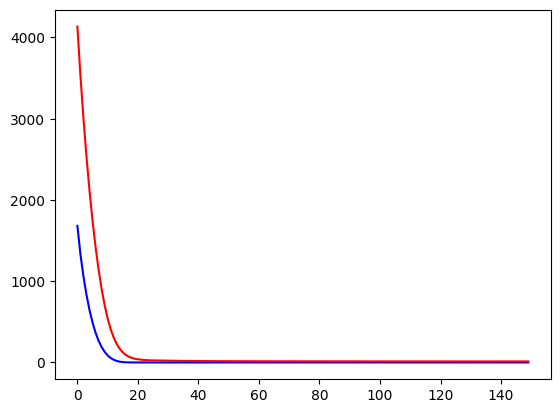

In [105]:
plt.plot(train_losses, '-b')
plt.plot(val_losses, '-r')
plt.show

In [ ]:
predictions = []
true = []

start, _ = test[0]
start = torch.reshape(start, (1,N_DOTS,N_DOT_PARAMETERS))

for i in range(1000):
    with torch.no_grad():
        pred = model(start)
        predictions.append(pred[0, -1, :])
        start[0, :-1, :] = start.clone()[0, 1:, :]
        start[0, -1, :] = pred[0, -1, :]
        # start = pred
_, y_true  = test[:1000]
_, last = train[:]

In [107]:
# # sts
# predictions = []
# true = []

# start, _ = test[0]
# start = torch.reshape(start, (1,N_DOTS,N_DOT_PARAMETERS))

# for i in range(1000):
#     with torch.no_grad():
#         pred = model(start)
#         predictions.append(pred[0, -1, :])
#         start = pred
#         # start = pred
# _, y_true  = test[:1000]
# _, last = train[:]

In [111]:
pred_data = pd.DataFrame([[0,0,0,0,0,0,0,0]], columns=["Time", "X", "Y", "Z","Vx","Vy","Vz","I"])

p_x = pd.DataFrame(np.vstack(list(map(lambda x: x.detach().numpy(), predictions))), columns=["Time", "X", "Y", "Z","Vx","Vy","Vz"])
p_x['I'] = "Predict"
_, y  = test[:]
p_y = pd.DataFrame(y.detach().numpy()[:, 0, :], columns=["Time", "X", "Y", "Z","Vx","Vy","Vz"])
p_y['I'] = "True"
p_last = pd.DataFrame(last.detach().numpy()[:, 0, :], columns=["Time", "X", "Y", "Z","Vx","Vy","Vz"])
p_last["I"] = "Last"

pred_data = pd.concat([pred_data,p_x,p_y,p_last],axis=0)


aaaab = pred_data.drop(pred_data.index[0], inplace=False)


In [113]:
fig = px.line_3d(aaaab, x="X", y="Y", z="Z", color='I',markers=0)
fig.show()